In [2]:
#Nye imports
import os
import pathlib
import gradio as gr
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from glob import glob
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split
from sklearn.ensemble import  RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score




# Definerer mappestruktur og legger all dataen i en tabell

#TODO Endre dette? 
Kanskje bruke Train_Test_Valid mappen vi har istedenfor å gå igjennom alle bildene og dele opp manuelt

In [14]:


input_dir = './Jellyfish'
categories = ['barrel_jellyfish','blue_jellyfish','compass_jellyfish','lions_mane_jellyfish','mauve_stinger_jellyfish','moon_jellyfish']

image_size = (32, 32)


data = []
labels = []

for category_idx, category in enumerate(categories):
    category_path = os.path.join(input_dir, category)
    image_files = glob(os.path.join(category_path, '*')) 
    
   
    for img_path in image_files:
        img = imread(img_path)
        img = rgb2gray(img)  
        img_resized = resize(img, image_size)  
        
        data.append(img_resized.flatten()) 
        labels.append(category_idx)        


data = np.array(data) / 255.0
labels = np.array(labels)

print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")

Data shape: (900, 1024), Labels shape: (900,)


# VISUALISERING⬇️

IndexError: list index out of range

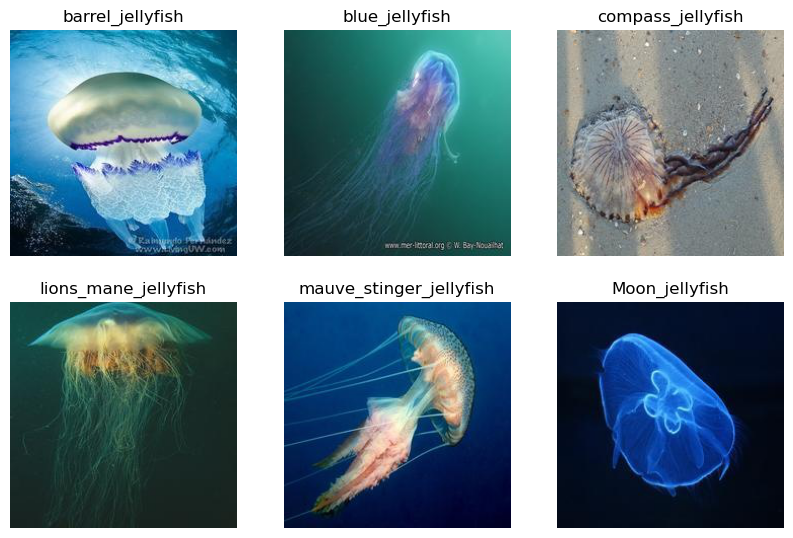

In [16]:
#Visualisere dataen

dataset_directory = r"./Jellyfish"

data_dir = pathlib.Path(dataset_directory)

image_count = 1

plt.figure(figsize=(10, 10))
for folders in data_dir.glob('*/'):

    image_files = list(folders.glob('*.jpg'))
    image_path = image_files[0]
    img = Image.open(image_path)
    ax = plt.subplot(3, 3, image_count)
    plt.imshow(img)
    plt.title(folders.name)
    plt.axis("off")
        
    image_count += 1  # Move to the next subplot

# Dele opp i trening, validering og testdata


In [17]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# TRENE MODELLEN
Hvis vi lar CatBoostClassifier kjøre >1000 iterasjoner så vil det forbedre resultatet  

In [16]:
model = CatBoostClassifier(iterations=1000, learning_rate=0.1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

0:	learn: 1.7560858	total: 2.64s	remaining: 43m 59s
1:	learn: 1.7256406	total: 4.95s	remaining: 41m 9s
2:	learn: 1.6988778	total: 7.11s	remaining: 39m 23s
3:	learn: 1.6700935	total: 9.16s	remaining: 37m 59s
4:	learn: 1.6427128	total: 10.7s	remaining: 35m 35s
5:	learn: 1.6211218	total: 12.4s	remaining: 34m 8s
6:	learn: 1.5972971	total: 13.9s	remaining: 32m 55s
7:	learn: 1.5784613	total: 15.5s	remaining: 32m 3s
8:	learn: 1.5563733	total: 17s	remaining: 31m 16s
9:	learn: 1.5373675	total: 18.6s	remaining: 30m 38s
10:	learn: 1.5213652	total: 20.1s	remaining: 30m 9s
11:	learn: 1.5047842	total: 21.7s	remaining: 29m 48s
12:	learn: 1.4884580	total: 23.3s	remaining: 29m 32s
13:	learn: 1.4704081	total: 24.9s	remaining: 29m 13s
14:	learn: 1.4507999	total: 26.4s	remaining: 28m 56s
15:	learn: 1.4373013	total: 28s	remaining: 28m 41s
16:	learn: 1.4291578	total: 29.5s	remaining: 28m 26s
17:	learn: 1.4144124	total: 31.1s	remaining: 28m 15s
18:	learn: 1.4061714	total: 32.7s	remaining: 28m 6s
19:	learn: 1

# Lagre Modell


In [22]:
model.save_model("./Modell/catboost_model.cbm")




# Accuracy

In [23]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 51.11%


# GRADIO NETTSIDE 

In [18]:
    
from click import launch

def klassifiserJellyfish(image):

   try:
        # Gjør om størrelsen på bildet til samme format som det vi lagde modellen på
        image_resized = resize(image, (32, 32), anti_aliasing=True)
        
        # Flater ut bildet og lager prediksjon
        image_flattened = image_resized.reshape(1, -1)
        prediction = model.predict(image_flattened)
        return categories[int(prediction[0])]
   except Exception as e:
       return "Insert image"

demo = gr.Interface(
    fn=klassifiserJellyfish,
    inputs=gr.Image( image_mode='L'),
    outputs=["label"],
    live = True,
    description="""
         Jellyfish Type Classifier! 🌊
        
        Upload an image of a jellyfish, and our model will identify its type. This classifier distinguishes between various types such as **Moon Jellyfish**, **Lion's Mane Jellyfish**, **Box Jellyfish**, and more!
        
        **How to Use**:
        1. Click on the image upload area to add a photo of a jellyfish.
        2. Wait a moment for the model to analyze the image.
        3. See the classification result displayed below!
        
        **Note**: For best results, please use a clear, centered photo of the jellyfish.
    """,
    examples=[[r"./Jellyfish/barrel_jellyfish/02.jpg"],
              [r"./Jellyfish//blue_jellyfish/02.jpg"],
              [r"./Jellyfish/compass_jellyfish/02.jpg"],
              [r"./Jellyfish/lions_mane_jellyfish/02.jpg"],
              [r"./Jellyfish/mauve_stinger_jellyfish/02.jpg"],
              [r"./Jellyfish/Moon_jellyfish/02.jpg"]
              ],  
    
    
    flagging_mode="never",  # Disable flagging for simplicity
    css="""
        body { font-family: Arial, sans-serif; }
        .container { border-radius: 8px; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.1); padding: 20px; }
        .title { color: #3178C6; font-size: 2em; font-weight: bold; }
        .description { color: #333; font-size: 1.1em; }
        .gradio-input, .gradio-output { border-radius: 8px; }
        .gradio-input input[type="file"] { border: none; padding: 10px; background-color: #f0f8ff; border-radius: 8px; }
        .output-text { font-size: 1.3em; color: #3178C6; font-weight: bold; }
    """
)

demo.launch()


* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.
